# Astro 304 "Galaxies"
## Galaxy  magnitudes, colors, sizes, luminosities, etc.

### Preliminaries: set up plotting parameters

In [1]:
import numpy as np

# setup notebook for inline figures
%matplotlib inline
import matplotlib.pyplot as plt

from code.plot_utils import plot_pretty
plot_pretty()

# allow automatic reload of imported codes, if they are modified
%load_ext autoreload
%autoreload 2

You can turn this notebook into a slide show using nbconvert package:

jupyter-nbconvert --to slides ex02_sdss_galaxies_images_spectra.ipynb --post serve

### Magnitudes of galaxies and magnitude systems

Astronomers use a logarithmic magnitude scale to quantify the apparent and intrinsic brightness of sources, which is akin to the historical visual magnitude system based on the roughly logarithmic sensitivity of our eyes.
$$m=-2.5\log_{10}f + \mathrm{const},$$<br>
where $f$ is flux from the source of luminosity $L$ at distance $d_{\rm L}$: $f=L/(4\pi d_{\rm L}^2).$

In practice flux is always observed within some limited range of wavelengths (band) in which device or filter is sensitive and magnitude and luminosity are measured within such band weighted by the instrumental response as a function of wavelength. 

The choice of filter(s) and the choice of how to calibrate/normalize the constant in the above equation define the <b>magnitude system.</b> 

### AB magnitude system used in the Sloan Digital Sky Survey (SDSS)

A number of different magnitude systems exist in the literature, especially in older papers. Modern magnitude systems, e.g. in the SDSS, are based on the AB-magnitude system introduced by <a href="http://adsabs.harvard.edu/abs/1983ApJ...266..713O">Oke & Gunn (1983)</a>.


Specifically, in the SDSS catalog magnitudes are defined using light from a limited range of wavelengths, defined by a filter. 
In the AB system this is given by (see <a href="http://adsabs.harvard.edu/abs/1996AJ....111.1748F">Fukugita et al. 1996</a>):
$$
m_f =-2.5\log_{10}\frac{\int f_{\nu}S(\nu) d(\log_{10}\nu)}{\int S({\nu}) d(\log_{10}\nu)} - 48.6,
$$
where $f_\nu$ is the specific flux per unit frequency.

The SDSS filter transmission curves, $S_\lambda$, can be found <a href="http://classic.sdss.org/dr7/instruments/imager/filters/">here</a>.  SDSS database reports spectra as the flux density per unit wavelength at a given $\lambda$, $f_\lambda$,  instead of $f_\nu$.  Converting from $f_\nu$ to $f_\lambda$  ($\nu=c/\lambda$, $d\nu=-cd\lambda/\lambda^2$, so $f_\nu=\lambda^2 f_\lambda/c$), the magnitude in a given 
filter can be expressed as:
$$
m_f =-2.5\log_{10}\left[\frac{10^{19.44}}{c}\frac{\int f_{\lambda}S(\lambda)\lambda d\lambda}{\int S({\lambda})\lambda^{-1} d\lambda}\right].
$$

### Absolute magnitudes

The absolute magnitude $M$ is the
astronomer's measure of luminosity, defined to be the apparent
magnitude the object in question would have if it were at 10 pc, so
$$
m=M+DM+E(z)+K(z)+e(z)
$$

where the <b>distance modulus</b> DM is defined by
$$
DM\equiv 5\,\log \left(\frac{d_{\rm L}}{10~{\rm pc}}\right)
$$
because it is the magnitude difference between an object's observed
bolometric flux and what it would be if it were at 10 pc (this
was once thought to be the distance to Vega which was the most commonly used standard star until recently).  

$E(z)$ is the <i>extinction correction</i>, which corrects for reddening of the galaxy light due to dust in the Milky Way. 

For stars we would not have the rest of the terms, $K(z)$ and $e(z)$, but for galaxies they are needed. 

### k-, and evolution corrections

The term $K(z)$ is the so called <b>$k$-correction</b>:
<br>
$$
K(\lambda_0) = 2.5\,\log \left[(1+z)\,\frac{\int_0^{\infty} f(\lambda_0) S(\lambda)d\lambda}{\int_0^\infty f[\lambda_0/(1+z)]S(\lambda)d\lambda}\right],
$$
where $\lambda_0$ is the wavelength of the filter at $z_0$ to which we would like to correct the magnitudes. Computing $k$-correction requires good knowledge of galaxy spectra and its calibration is a complex business. Code implementing $k$-corrections for galaxies at $z\leq 0.5$ can be found in <tt>code/calc_kcor.py</tt> Some of the catalogs we will use, already include pre-computed value of $k$-correction for each galaxy. 

$e(z)$ is <i>evolution correction</i>, which takes into account evolution of galaxies in order to compare them across wide range of redshifts. We will discuss it more shortly. 

### Galaxy luminosity

Given the galaxy absolute magnitude $M_{\rm f}$ estimated for a given filter using equations above, we can compute galaxy luminosity in units of solar luminosity in the same filter as 
$$
L_{\rm f} = 10^{0.4(M_{\odot,\rm f}-M_{\rm f})},
$$
where $M_{\odot,\rm f}$ is the absolute magnitude of the Sun in the same band (see, e.g., eq. 14 <a href="http://adsabs.harvard.edu/abs/2003ApJ...592..819B">Blanton et al. 2003</a> for the SDSS bands and <a href="http://mips.as.arizona.edu/~cnaw/sun.html">here</a> for many other commonly used bands).

Now that we've covered the definitions of magnitudes and how to convert them to luminosities, let's define a galaxy sample of SDSS galaxies and explore it. 

### SDSS DR8 galaxy sample

For many exercises here and subsequent lectures we will be using SDSS data. The binary FITS file used in the explorations below can be downloaded <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/SDSSspecgalsDR8full.fit">here</a> (it is 165 Mb). It was produced at the SDSS <a href="http://skyserver.sdss.org/CasJobs/">CasJobs server</a> where time-intensive SQL queries can be submitted. The FITS file used below is large because it includes a number of properties that will be useful in our explorations and because it selects almost all low-z galaxies from the SDSS (called the main galaxy sample, to differentiate from the quasar and LRG samples). 

The SQL script used to produce the FITS file below can be found <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/data/query_SDSSspecgalsDR8full.fit.txt">here.</a> Description of various entries for SDSS objects classified as GALAXY in DR8 can be found <a href="http://skyserver.sdss.org/dr8/en/help/browser/browser.asp">here</a>. If you have not queried SDSS data base yet, I encourage you to use this example, to create CasJobs account and construct your own queries for particular properties. This is not needed for the exercises, however. For these
I provide you data that is already downloaded. 

The code for reading SDSS fits file can be found in code/read_sdss_fits; uncomment the following line, if you want to see the code inline here in the notebook. 

routines <tt>notes_home_dir()</tt> and <tt>data_home_dir()</tt> in <tt>code/setup/setup.py</tt> should return top directory for your local repository copy and directory where data files are stored.

*Make sure you change my path in these routines to the paths of the corresponding directories on your laptop.* 

### Let's read the fits table with SDSS spectroscopic galaxy sample

In [2]:
from code.read_sdss_fits import read_sdss_fits
from code.setup.setup import data_home_dir

# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'SDSSspecgalsDR8full.fit')

In [3]:
# let's see the names of the quantities available in the SDSS table
from astropy.io import fits

hdulist = fits.open(data_home_dir()+'SDSSspecgalsDR8full.fit')

print(hdulist[1].columns.names)

['ra', 'dec', 'mjd', 'plate', 'fiberID', 'class', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'extinction_g', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'cmodelMag_u', 'cmodelMagErr_u', 'cmodelMag_g', 'cmodelMagErr_g', 'cmodelMag_r', 'cmodelMagErr_r', 'cmodelMag_i', 'cmodelMagErr_i', 'petroR50_r', 'petroR90_r', 'petroR50Err_r', 'petroR90Err_r', 'fracdeV_r', 'expRad_r', 'expRadErr_r', 'deVRad_r', 'deVRadErr_r', 'deVMag_r', 'deVMagErr_r', 'expMag_r', 'expMagErr_r', 'lnLDeV_r', 'lnLExp_r', 'deVAB_r', 'deVABErr_r', 'expAB_r', 'expABErr_r', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID']


If you want to get info on different quantities in the list above, consult <a href="https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx">SDSS DR8 Galaxy table schema browser.</a> However, this is not needed as we will discuss the relevant quantities below. 

We will first focus on magnitudes and sizes. 

Many of the quantities in the list above have <tt>Mag</tt> in their name. These are *magnitudes*, but why are there so many of them?

The first two magnitudes in the list are <tt>petroMag_r</tt> and <tt>psfMag_r</tt>. The latter is magnitude that accounts for all the light within the point spread function (PSF) of the telescope. For stars this is all we would ever need. Not so for galaxies...

### The challenge of measuring galaxy luminosities

The flux density, $f_\lambda$, has a simple meaning, but its measurement is often non-trivial in practice because it requires integration of photons over some area on the sky. For point sources like stars and quasars the total flux can simply be collected from an area that encloses the telescope point spread function, although for stars in crowded regions even this task is non-trivial. Galaxies, however, are intrinsically extended and diffuse (as discussed earlier, this is the reason they were dubbed ``nebulae'') and collecting flux associated with galaxies requires either defining a galaxy boundary or devising some way to calculate the total flux. 

The difficulty is reflected in a variety of ways that galaxy magnitudes are computed. Whenever you hear about galaxy luminosity or stellar mass (or half-light radius) you should be aware of the method used to compute magnitudes from which these quantities are derived.

<tt>petroMag_r</tt> in the list above is the so-called *Petrosian magnitude.* It is the first example of magnitude that is designed specifically for galaxies with their diffuse and extended light distribution.

In fact, the main spectroscopic galaxy sample in the SDSS is defined using a limiting *Petrosian magnitude* in the $r$-band of 17.77. What is the Petrosian magnitude exactly?

Before we discuss this, we need to introduce the key concept in galaxy photometry and studies of galaxies: surface density of light and related surface brightness of galaxies. 

### Surface brightness.

Another important property is galaxy surface brightness, defined as the amount of light that we receive from a given area of the galaxy. This quantity makes sense for extended object where we can compare amount of light we get from an area from the total amount of light we can get from a point source. 

We cannot estimate luminosity without distance, but we can compute surface brightness in units of magnitude per square arcsec - i.e., the flux in the $r$-band magnitudes we receive from an area $d\Omega$ in $\mathrm{arcsec}^2$: $\mu_r=-2.5\log_{10}(f_r/d\Omega) + \mathrm{const}=m_r+2.5\log_{10}d\Omega$.

Note that 1 arcsec$^2$ in steradians is 

$$\Omega_1=\left(\frac{\pi}{180\times 60\times 60}\right)^2=2.35\times 10^{-11}.$$ 

### Relation between surface density and surface brightness (is distance independent)

The choice of  $d\Omega$ depends on one's goals. For example, we can define $d\Omega$ to be an annulus of radius $R$ and thickness $\Delta R$, as is done in the estimates of the Petrosian magnitudes (see below). 
Or we can estimate surface brightness in equal size square (or other shape) patches of a given $d\Omega$.

Note that we can always express the flux $f_{\rm f}$ in the above equation in terms of intrinsic luminosity in the same filter: $f_{\rm f}\propto L_{\rm f}/d^2$, where $d$ is galaxy distance. Thus, $\mu_{\rm f}$ and  $\Sigma_{\rm f}=L_{\rm f}/\mathcal{A}$, where $\mathcal{A}$ is a physical area (see Appendix A.5 in the class notes for the exact relation) are related via distance independent relation:

$$\Sigma=10^{-0.4\mu},$$

and we can talk about $\mu_{\rm f}$ and $\Sigma_{\rm f}$ interchangeably.

### Petrosian magnitudes 

<a href="http://adsabs.harvard.edu/abs/1976ApJ...209L...1P">Petrosian (1976)</a> proposed to measure radii based on the integrated galaxy flux to make such estimates more robust. The idea is that as one traces the surface brightness profile $\Sigma(R)$, one can compare the light within some shell of thickness $\Delta R/R$, $\Delta \Sigma$, to the total light within $R$, $\Sigma(\le R)$ and define the galaxy (Petrosian) radius, $R_{\rm P}$, as the radius corresponding to $\Delta \Sigma=\eta \Sigma(\le R_{\rm P})$. One could then tune $\eta$ in such a way that the measurement recovers all or most of the flux for a particular assumed form of the profile $\Sigma(R)$ extending to infinity. 


Specific implementation of this definition in the SDSS  (see <a href="http://skyserver.sdss.org/dr1/en/help/docs/algorithm.asp?key=mag_petro">here</a> for more details) computes the following function as a function of angular radius, $R$, from galaxy center:
$$
\eta(R)\equiv\frac{\int_{0.8R}^{1.25R}dR^\prime 2\pi R^\prime \Sigma(R^\prime)/[\pi(1.25^2-0.8^2)R^2]}{\int^R_02\pi R^\prime \Sigma(R^\prime) dR^\prime/(\pi R^{2})}
$$
where $\Sigma(r)$ is the surface brightness profile. The <b>Petrosian radius</b>, $R_{\rm P}$, is then defined by the SDSS pipeline as the radius where $\eta(R_{\rm P})=0.2$.
Galaxy flux is then measured within some multiple of $R_{\rm P}$:
$$
F_{\rm P}\equiv \int^{N_{\rm P}R_{\rm P}}_0 2\pi R^\prime \Sigma(R^\prime)dR^\prime
$$
The aperture $2R_{\rm P}$ used in the SDSS measurements. 

### Petrosian magnitudes: continued

The choices for $\eta$ and $N_{\rm P}$ are heuristic. $N_{\rm P}$ is chosen to be large enough to contain nearly all of the flux for many galaxies (in particular late type galaxies described by the exponential profile), but small enough that the sky noise is sub-dominant in the estimate of $F_{\rm P}$. In this case, even substantial errors in $R_{\rm P}$ cause only small errors in the Petrosian flux (typical statistical errors near the spectroscopic flux limit of $r \sim 17.7$ are $< 5\%$). The 
 main draw of the Petrosian's definition, however, is that the fraction of recovered light is robust and depend  only weakly on the galaxy axis ratio or size variation due to worse seeing or greater distance. 

One can show that theoretically the Petrosian magnitudes defined as in the SDSS should recover almost all of the flux of an exponential galaxy profile and about 80% of the flux for a de Vaucouleurs profile.

However, galaxy surface brightness profiles are often described by different functions (corresponding to different components) at different radii. Thus, in practice the Petrosian magnitude may underestimate total galaxy light by $\approx 0.2-0.5$ mag. The magnitude of the underestimate depends on the fraction of light in the outer component, which increases with increasing galaxy luminosity. 
 
Thus, this underestimate will affect the brightest galaxies the most (see <a href="http://adsabs.harvard.edu/abs/2013MNRAS.436..697B">Bernardi et al. 2013)</a>). This issue will come up in the practical calculation of the galaxy luminosities and luminosity function we will discuss next week. 

### Petrosian magnitudes and radii in SDSS, light concentration

The Petrosian radius in each band is the parameter <tt>petroRad</tt> in the SDSS database with the subscript corresponding to 
particular filter (e.g., for $r$-band, <tt>petroRad_r</tt>) and the Petrosian magnitude in each band (calculated using only petroRad for the $r$ band) is the parameter petroMag (e.g., for $r$-band, <tt>petroMag_r</tt>) . 

SDSS main galaxy sample  also provides radii enclosing 50% and 90% of the total light of the Petrosian magnitude (e.g., <tt> petroR50_r</tt> and <tt>petroR90_r</tt> for the $r$ band). All these radii in the catalogs are measured in units of *arcseconds*. 

<tt>petroR50_r</tt> and <tt>petroR90_r</tt> can be used to define <b>concentration</b> of galaxy light in the $r$-band:
$$c_r = {\tt petroR90\_r/petroR50\_r},$$
which describes how compact is the surface brightness profile. For example, for the exponential profile concentration is $c=2.318$. 

As we will see, concentration is one of the quantities that correlate with galaxy morphology and can be measured fairly reliably even for faint galaxies, for which visual morphology is difficult to determine. In many studies concentration is thus used as a "proxy" for traditional morphological types (e.g., <a href="http://adsabs.harvard.edu/abs/2001AJ....122.1861S">Strateva et al. 2001</a>). 

### model magnitudes

An alternative way is to estimate total magnitude by using an extrapolation of the model for surface brightness profiles obtained via a fit to the regions of the galaxy where the light profile is measured reliably. The total model magnitude is then obtained by integrating the best fit model profile to infinity. 

The SDSS pipeline measures <a href="http://classic.sdss.org/dr7/algorithms/photometry.html">two kinds of model magnitudes</a> based on fits of the exponential and de Vaucouleurs profiles to each galaxy in the $r$-band (the most sensitive band). The goodness of fit is evaluated for each of these models and the profile 
providing a better fit is chosen as the surface brightness profile model for computing SDSS model magnitudes. The model magnitudes are then computed by integrating this model to infinity.

### Models of surface density and surface brightness profiles

### Exponential profile 

The exponential profile is thus given by:

$$\Sigma(R) = \Sigma_0\,\exp\left(-\frac{R}{R_d}\right),$$
where $R_d$ is the characteristic scale length of the profile and $\Sigma_0$ is surface brightness at $R=0$. Often, the expression for the profile is recase in terms of the *effective radius* that encloses half of the total light of the profile and surface brightness within this radius, $\Sigma_e=\Sigma(R_e)$. To determine relation between $R_d$ and $R_e$, we write relation for total luminosity emitted within radius $R$:

$$
L(<R)=2\pi\Sigma_0\int\limits_0^R R^\prime\exp(-R^\prime/R_d) dR^\prime. 
$$
Substituting $x=R/R_d$ and integrating by parts gives:
$$
L(<R) = 2\pi\Sigma_0 R_d^2\left[1-\frac{R}{R_d}e^{-R/R_d}-e^{-R/R_d}\right].
$$
For $R_\infty$ this gives total light for the exponential profile: $L_{\rm tot}=2\pi\Sigma_0 R_d^2,$ so that a given fraction of light $\eta$ within a given $R$ is given by:
$$
\frac{L(<R)}{L_{\rm tot}}=1-\frac{R}{R_d}e^{-R/R_d}-e^{-R/R_d}=1-xe^{-x} - e^{-x},
$$
which can be solved numerically. For $\eta=0.5$ this solution gives $x_{0.5}=R_e/R_d\approx 1.678$. Thus we can re-write the exponential profile as

$$\Sigma(R) = \Sigma_0\,\exp\left(-1.678\frac{R}{R_e}\right)=\Sigma_e\,\exp\left\{-1.678\left(\frac{R}{R_e}-1\right)\right\},$$
where $\Sigma_e=\Sigma(R_e)$.

Taking a natural log of the above expression and relation between $\Sigma$ and $\mu$ above, we get: 
$$\mu(R)=\mu_e+\frac{2.5\times 1.678}{\ln(10)}\left[\frac{R}{R_e}-1\right].
$$


### De Vaucouleurs  profile

The de Vaucouleurs surface density profile is given by:
$$\Sigma(R) = \Sigma_0\,\exp\left[\left(-\frac{R}{R_d}\right)^{1/4}\right],$$
which analogously can be re-written in terms of the half-light radius $R_e$: 
$$\Sigma(R) = \Sigma_e\,\exp\left\{-7.669\left[\left(\frac{R}{R_e}\right)^{1/4}-1\right]\right\},$$
where the numerical constant 7.669 is obtained via numerical solution of the equation for the half light radius. The total luminosity of a galaxy with the De Vaucouleurs profile is given by $L_{\rm tot}=8\pi\, 7!\Sigma_0 R_d^2.$

Taking natural log of the second expression for $\Sigma(R)$ above and using relation between $\Sigma$ and $\mu$ we get expression for the surface brightness in magnitudes per solid angle. 
$$
\mu(R)=\mu_e+\frac{2.5\times 7.669}{\ln(10)}\left[\left(\frac{R}{R_e}\right)^{1/4}-1\right].
$$

The exponential and De Vaucouleurs profiles are specific instances of a more general family of the *$\mathrm{Sers\acute{\imath}c}$ profiles.* We will return to these profiles in a different context in the near future. 

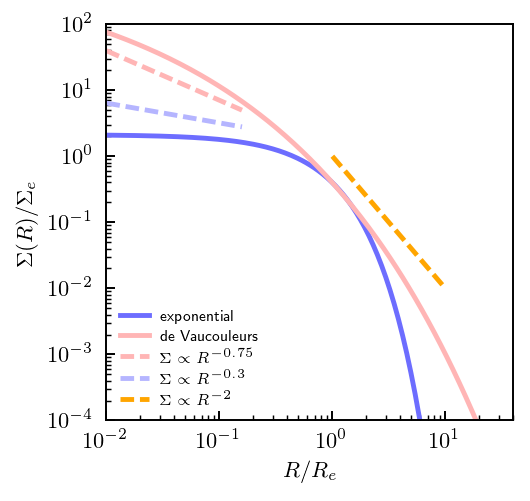

In [4]:
import matplotlib.cm as cm
import matplotlib.colors as colors

fig = plt.figure(figsize=(3, 3))

plt.xlabel ('$R/R_e$')
plt.ylabel (r'$\Sigma(R)/\Sigma_e$')

plt.xlim(0.01, 40.); plt.ylim(0.0001, 100.)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=10)

x = np.linspace(-2., 1.7, 200)
x = np.power(10.,x)
me = 1.0; Re=1.0

cnorm  = colors.Normalize(vmin=1, vmax=15)
scalarmap = cm.ScalarMappable(norm=cnorm, cmap=cm.seismic)

# constract surface brightness profiles
labels = ['exponential', 'de Vaucouleurs']
for i, n in enumerate([1,4]):
    bn = 1.9992*n-0.3271
    spro = np.power(10.0,-0.4*(me + 2.5*bn*(np.power(x/Re,1.0/n)-1.0)/np.log(10.)))
    color = scalarmap.to_rgba(n+5)
    if n != 3: plt.plot(x,spro,'-', c=color, lw=2.0, label=labels[i])

# plot power law for comparison:
x1 = np.linspace(-2., -0.8, 5); x2 = np.linspace(0., 1., 5)
x1 = np.power(10.,x1); x2 = np.power(10.,x2)
y1 = 1.6*np.power(x1,-.3); y2 = 1.*np.power(x2,-2.0)
y3 = 1.25*np.power(x1,-0.75)
#
color = scalarmap.to_rgba(4+5)
plt.plot(x1,y3,'--', c=color, lw=2.0, label=r'$\Sigma\propto R^{-0.75}$')
color = scalarmap.to_rgba(2+5)
plt.plot(x1,y1,'--', c=color, lw=2.0, label=r'$\Sigma\propto R^{-0.3}$')
plt.plot(x2,y2,'--', c='orange', lw=2.0, label=r'$\Sigma\propto R^{-2}$')

plt.legend(loc='lower left', frameon=False, fontsize=6)
#plt.grid()
plt.savefig('fig/exp_deV_pro.png', bbox_inches='tight')
plt.show()


<img width=500 align=left src="fig/exp_deV_pro.png"></img>

### cmodel magnitudes

On the other hand, cmodel magnitudes use  surface brightness profile model constructed as a linear combination of  the exponential and de Vaucouleurs models used to define model magnitudes in the $r$ band: $F_{\rm composite} = {\rm fracDeV} \cdot F_{\rm deV} + (1 - {\rm fracDeV}) F_{\rm exp}$,
where $F_{\rm deV}$ and $F_{\rm exp}$ are the de Vaucouleurs and exponential surface brightness profiles computed using the corresponding independent model fits in the $r$ band. 

The cmodel magnitude is computed using fracdeV value that fits they surface brightness profile of a particular galaxy best. Among the magnitudes available for galaxies in the SDSS database, these magnitudes are recommended as the best choice for estimating galaxy luminosities and other physical properties. As we will see next week, however, for bright galaxies they still significantly underestimate the total light. So yet more sophisticated methods are employed to measure total galaxy light and sizes.

### Defining SDSS galaxy sample

First we construct a galaxy sample using some general cuts to remove problematic objects: objects with peculiar colors or redshifts, bright nearby objects that SDSS pipeline often splits into multiple objects, etc. 

We also will also limit the sample to objects brighter than $r$-band magnitude of $m_r=17.77$, because SDSS only targeted galaxies brighter than this limit for spectra measurements. 

In [5]:
import numpy as np

# lower limit on z is to avoid the nearest galaxies for which SDSS pipeline often does 
# not perform well (splitting them into pieces, etc)
# with z_min=0.005 we are excluding galaxies closer than the Virgo cluster ~16 Mpc away from the Milky Way
# z_max=1.0 is to avoid misclassified objects that appear as very high z systems
z_min = 0.005; z_max = 1.0

# magnitude cuts appropriate for the SDSS main spectroscopic sample 
m_min = 12.0; m_max = 17.77

# correct r-band Petrosian magnitudes for Galactic extinction before applying magnitude cuts
mr = data['petroMag_r'] - data['extinction_r']
cmr = data['cmodelMag_r'] - data['extinction_r']
cmg = data['cmodelMag_g'] - data['extinction_g']
gr = cmg - cmr

# apply redshift, magnitude, and color cuts
data = data[(data['z'] > z_min) & (data['z'] < z_max) & (mr > m_min) & (mr < m_max) & (gr>-2.5) & (gr<2.5)]

print("selected %d galaxies"%np.shape(data['z']))


selected 650045 galaxies


In [6]:
from code.cosmology import d_l
# now compute luminosity and angular diameter distances for galaxies in the sample
Om0 = 0.3; OmL = 0.7
h = 0.7 # H0/100
d_H = 2997.92 # c/(100 km/s/Mpc) 

z = data['z']

d_L = d_l(z, Om0, OmL, ninter=20)
d_A = d_L / (1.+z)**2
    
# convert to /h Mpc
d_L *= d_H; d_A *= d_H


In [7]:
# Petrosian and cmodel magnitudes in the r band, extinction corrected. 
mpetro = data['petroMag_r'] - data['extinction_r']
mcmodel = data['cmodelMag_r'] - data['extinction_r']

# cmodel and Petrosian absolute magnitudes in the r-band
Mcmodel = mcmodel - 5.0*np.log10(d_L/1e-5)
Mpetro = mpetro - 5.0*np.log10(d_L/1e-5)

# now account for evolution and apply K-correction

# g-r color for computing K-correction using cmodel magnitudes
gr = data['cmodelMag_g'] - data['extinction_g'] - data['cmodelMag_r'] + data['extinction_r']

# absolute magnitude in the r-band; apply +1.3*z correction for evolution (see Bernardi et al. 2010)
# and k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
from code.calc_kcor import calc_kcor 
# this k-correction is not designed for z>0.6, so limit the z for correction calculation
ihz = [z>0.6]; zk = np.copy(z); zk[ihz] = 0.6
kcorr = calc_kcor('r', zk, 'g - r', gr)

Mcmodel = Mcmodel + 1.3*z - kcorr 
Mpetro  = Mpetro + 1.3*z - kcorr

# finally, compute r-band luminosity in Lsun,r from the cmodel and Petrosian absolute mmagnitudes
Lcmodel =  10.**(0.4*(4.67-Mcmodel))
Lpetro =  10.**(0.4*(4.67-Mpetro))

### Collage of thumbnail images of SDSS galaxies from the spectroscopic sample

Display a random selection of galaxies with a given range of parameters in an array (collage) of thumbnail images. This is an example of how you can display SDSS images of select galaxies in a grid of thumbnail images. You can use this example to create a gallery of the Milky Way analogues in the homework 1, by suitably modifying selection criteria. 

The code queries SDSS to get galaxy image. Thus, you should be connected to the internet for it to work.  

selected 153055 galaxies


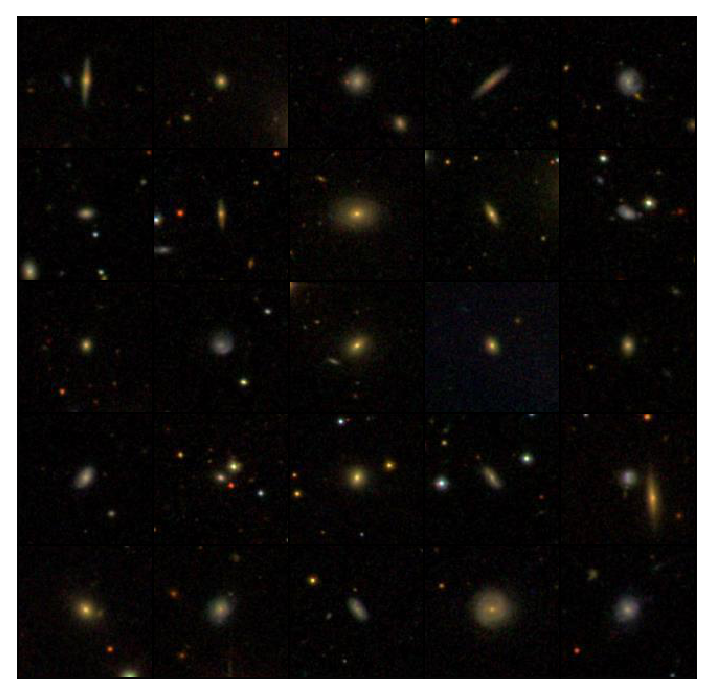

In [11]:
from code.plot_utils import sdss_img_collage

# the number of rows and columns in the image collage
nrow = 5; ncol = 5
# pixel size of the thumbnails to extract from the SDSS
npix = 130

# minimum and maximum luminosity distances for galaxy selection
Dmin = 200.; Dmax = 300.; 
# absolute magnitude limit on the faint end
Mlim = -11.0

# select galaxies with these distance and absolute magnitude limits
rdata = data[(Mcmodel < Mlim) & (d_L > Dmin) & (d_L < Dmax)]

print("selected %d galaxies"%np.size(rdata))
# select a random subset of galaxies from the selected subset
iran = np.random.randint(0., np.size(rdata)-1, nrow*ncol)
# get data for the randomly selected galaxies
dshow = rdata[iran]
objs = dshow['objID']; ras = dshow['ra']; decs = dshow['dec']

# get images (if they are not yet on disk) and display the collage 
# make sure img/ subdirectory exists within directory where this notebook is located
sdss_img_collage(objs, ras, decs, nrow, ncol, npix, scale=0.5)

### Galaxy spectra and colors

Now let's plot some galaxy images and spectra and examine properties of galaxies of different appearance. The script below uses routine plot_image_spec_sdss_galaxy in the eponymous file in code/ . Look in code/plot_image_spec_sdss_galaxy.py if you wish to examine how it works. The code takes info on an object in the SDSS and queries SDSS to get its image and spectrum. Thus, you should be connected to the internet for it to work.  

color limits: 0.20 0.55

caching to C:\Users\h2_sf\astroML_data\SDSSspec\2216\spSpec-53795-2216-118.fit
computed g-r = 0.75
catalog g-r = 0.55


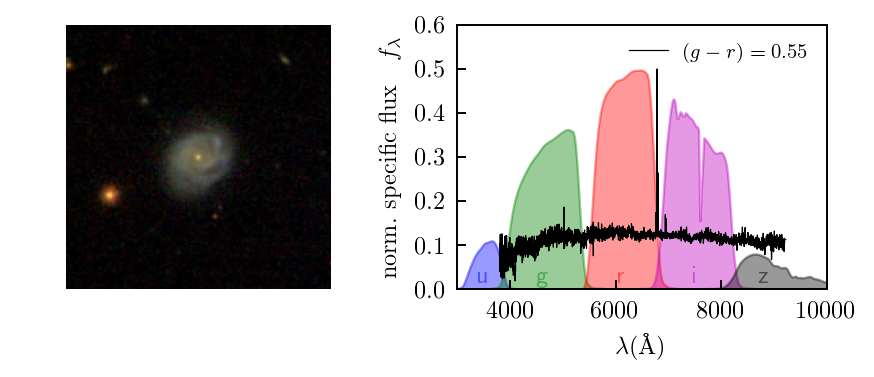

color limits: 0.55 0.65

caching to C:\Users\h2_sf\astroML_data\SDSSspec\0729\spSpec-52468-0729-297.fit
computed g-r = 0.89
catalog g-r = 0.82


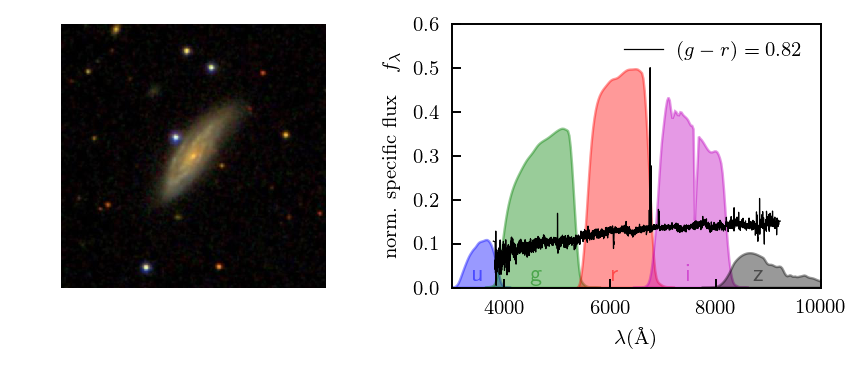

color limits: 0.65 0.75

caching to C:\Users\h2_sf\astroML_data\SDSSspec\1228\spSpec-52728-1228-008.fit
computed g-r = 0.87
catalog g-r = 0.79


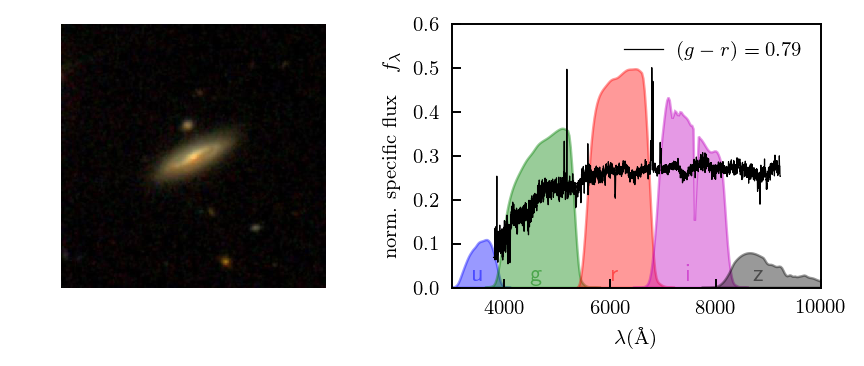

color limits: 0.75 1.00

caching to C:\Users\h2_sf\astroML_data\SDSSspec\1722\spSpec-53852-1722-116.fit
computed g-r = 0.92
catalog g-r = 0.89


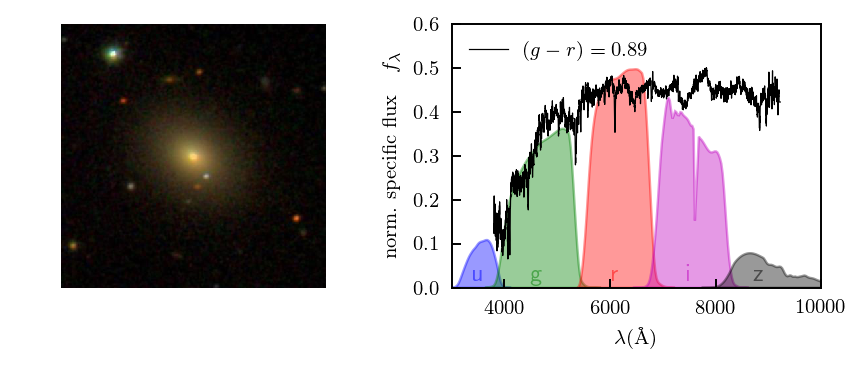

In [9]:
from code.plot_utils import plot_image_spec_sdss_galaxy

cbins = [0.2,0.55,0.65,0.75,1.0]

for ic, c in enumerate(cbins[:-1]):
    colsel = data[(gr>c) & (gr<cbins[ic+1]) & (d_A<100) & (Mcmodel < -20.)]
    print("color limits: %.2f %.2f"%(c, cbins[ic+1]))
    iran = np.random.randint(0,np.size(colsel)-1,1)
    randobj = colsel[iran]
    figname = 'figtmp/gal_img_spec'+'_'+str(randobj['objID'])+'.pdf'
    plot_image_spec_sdss_galaxy(randobj) #, save_figure=figname)

Compare the apsectra above to the spectra of stars of different type (see <a href="http://adsabs.harvard.edu/abs/1984ApJS...56..257J">Jacoby et al. 1984</a> for a comprehensive library of stellar spectra):

<img src="https://www.cliffsnotes.com/assets/23383.jpg"></img>

### Homework 1 (25 points) 
The entire homework is due next Thursday, Apr 5 (10pm). 

However, you will need to do part 1a and 1b by the class time on Tuesday, Apr 3, as pre-class questions and discussion will start with that will rely on this exercise. Be prepared in class on Tuesday to show and discuss your rogue gallery of the Milky Way analogues.

### 1. (15 points) Milky Way analogues.

#### Background info.
The Milky Way is a galaxy of the morphological type intermediate of SBb and SBc, although there is some uncertainty and debate about the exact type. 
You can see what is thought to be best guesses for the Milky Way counterparts in Figure 2 of the ARAA review of <a href="http://adsabs.harvard.edu/abs/2016ARA%26A..54..529B">Bland-Hawthorn and Gerhard (2016)</a> on the Milky Way properties in the context of the overall galaxy population. The images are originally from <a href="http://adsabs.harvard.edu/abs/2011ARep...55..108E">Efremov (2011).</a>  

Milky Way's half-light radius is $R_{50,\rm MW}\approx 4.4\pm 0.2\ \mathrm{kpc}$. For example, <a href="http://adsabs.harvard.edu/abs/2016ApJ...831...71L">Licquia & Newman (2016)</a> estimate the scale length of the Milky Way disk to be $R_{d,\rm MW}=2.63\pm 0.13$ kpc and that $\approx 85\%$ of the stellar mass in the exponential disk. We can thus estimate the half-mass radius as $R_{50}\approx 1.678\, R_{\rm d}$ (see S 1.3.1 in the class <a href="http://astro.uchicago.edu/~andrey/classes/a304s18/a304_galaxies_notes.pdf">notes</a>). Absolute $r$-band luminosity of the Milky Way and its $g-r$ color are estimated to be $M_{r,\rm MW}-5\log_{10}h=-20.97\pm 0.38$ and $(g-r)_{\mathrm{MW}}=0.678^{+0.069}_{-0.057}$ (see Table 7 in <a href="http://adsabs.harvard.edu/abs/2016ApJ...831...71L">Licquia & Newman (2016)</a>)

#### Tasks.

(a) Select nine (or more) images of galaxies that could be considered to Milky Way counterparts that are selected according to some suitable criteria. 

Explore selection of galaxies closest to the Milky Way 
in half-light radius, $R_{50}$, $r$-band absolute magnitude, $M_r$, $g-r$ color, and concentration $c=R_{90}/R_{50}$. (Estimates of these properties for the Milky Way are given above, except for concentration; use creative thinking to figure out an appropriate value of concentration). 

Select your favorite collage of the Milky Way analogues that matches the Milky Way morphology best and present it as part of your solutions to this exercise along with discussion of which parameters work best for this selection. 

(b) Examine images of the objects in the gallery that you think best matches Milky Way morphology and describe their appearance and color. Briefly discuss any similarities and differences that you notice between different galaxies. 
<br><br>

#### Tips
You can use example above showing how to create a collage of random galaxy images, but modify it to select galaxies close to the Milky Way instead of random. 

The best results will be obtained if you limit the galaxy sample from which you draw to within a maximum distance of $\sim 100-200$ Mpc. 
SDSS data table used above contains information about ellipsoidal axes ratio of the best fit surface brightness model (de Vaucouleurs or exponential) for each galaxy. These can be combined into a weighted average axes ratio as follows 

    fracdeV_r = data['fracdeV_r'] 
    ab = fracdeV_r*data['deVAB_r'] + (1.0 - fracdeV_r)*data['expAB_r']

Limiting galaxies to small $a/b$ ratios (say $ab<0.3$) will select disk galaxies viewed close to edge-on, while limiting to large $a/b$ ratios (say $ab>0.6$) will select disk galaxies viewed close to face on. 

### 2. (10 points) Surface brightness of the Milky Way.

### Task.
Compute the $r$-band surface brightness of the Milky Way within $R_{50}$ in magnitudes per square arcsecond, as it would be seen by an extragalactic observer, using Milky Way properties provided above. Show intermediate steps of your calculation. 
<br><br>